In [1]:
# Imports
import matplotlib.pyplot as plt
import phonopy
from monty.serialization import loadfn
import pandas as pd
import numpy as np
import re
import gc
import scipy.constants
from scipy import interpolate
from scipy.signal import find_peaks 
import math
import os

/home/gkrenzer/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Read the database lookup file

In [2]:
dir_db = #phonon_db directory

In [3]:
# Create a dataframe
df = loadfn(dir_db+'/phonon_db_lookup_df.json')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/gabrielkrenzer/Documents/PhD/projects/unsupervised_ml/phononDB/phonon_db_lookup_df.json'

Get the species with Li element

In [4]:
def element_filtered_dataframe(df, element):
    """A function which filters a dataframe for a particular element and returns a new dataframe with only entries containing that element.
    
    Input:
        df (pd.DataFrame): The original dataframe which describes the database
        element (str): The element which you want to query the dataframe for.
    Output:
        filtered_df (pd.DataFrame): A new dataframe with only entries which contain the element of interest"""
    
    return df.loc[df['chemsys'].str.contains(element)].reset_index(drop=True)

Li_df = element_filtered_dataframe(df,'Li')
print(f'Of the {df.shape[0]} materials in this dataset, {Li_df.shape[0]} contain lithium \n')

Li_df

Of the 10034 materials in this dataset, 873 contain lithium 



,material_id,elements,formula_pretty_reduced,formula,num_elements,chemsys,spacegroup_symbol,spacegroup_number,FORCE_SETS_filepath,phonon_filepath
0,mp-8892,"[Li, F, In]",LiInF4,Li4 In4 F16,3,F-In-Li,Pbcn,60,phonon_db/mp-8892-20180417/FORCE_SETS,phonon_db/mp-8892-20180417/phonon.yaml
1,mp-772968,"[Li, Tl, P, H, O]",LiTlPHO3,Li4 Tl4 P4 H4 O12,5,H-Li-O-P-Tl,C2,5,phonon_db/mp-772968-20180417/FORCE_SETS,phonon_db/mp-772968-20180417/phonon.yaml
2,mp-756951,"[Li, Sb, O]",LiSbO3,Li4 Sb4 O12,3,Li-O-Sb,C2/m,12,phonon_db/mp-756951-20180417/FORCE_SETS,phonon_db/mp-756951-20180417/phonon.yaml
3,mp-754856,"[Li, Y, Zr, S]",Li7Y7ZrS16,Li7 Y7 Zr1 S16,4,Li-S-Y-Zr,P2/m,10,phonon_db/mp-754856-20180417/FORCE_SETS,phonon_db/mp-754856-20180417/phonon.yaml
4,mp-24610,"[H, Li, O, P]",LiP(HO2)2,Li4 P4 H8 O16,4,H-Li-O-P,Pna2_1,33,phonon_db/mp-24610-20180417/FORCE_SETS,phonon_db/mp-24610-20180417/phonon.yaml
...,...,...,...,...,...,...,...,...,...,...
868,mp-9919,"[Li, Zn, Sb]",LiZnSb,Li2 Zn2 Sb2,3,Li-Sb-Zn,P6_3mc,186,phonon_db/mp-9919-20180417/FORCE_SETS,phonon_db/mp-9919-20180417/phonon.yaml
869,mp-14704,"[Li, B, O, Y]",Li6Y(BO3)3,Li24 Y4 B12 O36,4,B-Li-O-Y,P2_1/c,14,phonon_db/mp-14704-20180417/FORCE_SETS,phonon_db/mp-14704-20180417/phonon.yaml
870,mp-557756,"[Li, Zn, P, O]",Li4Zn(PO4)2,Li16 Zn4 P8 O32,4,Li-O-P-Zn,P2_1/c,14,phonon_db/mp-557756-20180417/FORCE_SETS,phonon_db/mp-557756-20180417/phonon.yaml
871,mp-966801,"[Li, Ca, B, O]",LiCaBO3,Li8 Ca8 B8 O24,4,B-Ca-Li-O,Ibca,73,phonon_db/mp-966801-20180417/FORCE_SETS,phonon_db/mp-966801-20180417/phonon.yaml


An extra variable 'formula' for reading Li pdos later in this notebook

In [5]:
formula = Li_df['formula'].str.split(" ", n=-1, expand=True)

# Get DOS data

The folder path will contain all dos and pdos files in dat format for 873 species containing lithium.

In [6]:
folder_path = #path of the folder

In [7]:
def loading (index):
    '''loading file from the database'''
    phonon_filepath = dir_db+'/'+Li_df['phonon_filepath'][index]
    print(phonon_filepath)
    force_sets_filepath = dir_db+'/'+Li_df['FORCE_SETS_filepath'][index]
    print(force_sets_filepath)

    ph = phonopy.load(phonon_filepath, force_sets_filename=force_sets_filepath, log_level=1)
    
    return ph

In [8]:
def separate_text (string):
    '''Separate string e.g. Li2 into Li and 2'''
    match = re.match(r"([a-z]+)([0-9]+)", string , re.I)
    if match:
        res = match.groups()
        
    return res

In [9]:
def find_Li_entry (index):
    '''Return a list of entries for Li atom pdos in dat file'''
    temp = {}
    shape = np.shape(formula)
    length = shape[1]
    for i in [*range (0, length)]:
        if formula.loc[index,i] != None:
            t = formula.loc[index,i]
            res = separate_text(t)
            temp[res[0]] = int(res[1])

    keys = [*temp.keys()]

    if keys[0] == 'Li':
        no_of_entry = temp['Li']
        entry = [*range(1,no_of_entry+1)]

    elif keys[0] != 'Li':
        Li_index = keys.index('Li')
        index_list = [*range(0,Li_index)]
        start = 0
        for i in index_list:
            start += temp[keys[i]]
        start += 1
        no_of_entry = temp['Li']
        entry = [*range(start, start + no_of_entry)]

    return entry

In [10]:
def find_unmatch ():
    '''not necessary, only if pdos file has less atom data than actual formula'''
    
    all_index = [*range (0, Li_df.index[-1]+1)] 
    unmatch = []
    
    for index in all_index:
        temp = {}
        shape = np.shape(formula)
        length = shape[1]
        for i in [*range (0, length)]:
            if formula.loc[index,i] != None:
                t = formula.loc[index,i]
                res = separate_text(t)
                temp[res[0]] = int(res[1])

        keys = [*temp.keys()]

        total_entry = 0
        for i in keys:
            total_entry += temp[i]

        total_entry += 1 #inclue the frequency row
        
        file = np.loadtxt(os.path.join(folder_path, "projected_dos_{0}.dat".format(index)),unpack = True)
        shape = np.shape(file)
        file_entry = shape[0]
        
        if total_entry != file_entry:
            unmatch.append(index)
            
        return unmatch

In [11]:
def find_total_no_atoms ():
    '''find total no of atoms in a unit cell'''

    all_index = [*range (0, Li_df.index[-1]+1)]
    total_no_atoms = {}
    for index in all_index:
        temp = {}
        shape = np.shape(formula)
        length = shape[1]
        for i in [*range (0, length)]:
            if formula.loc[index,i] != None:
                t = formula.loc[index,i]
                res = separate_text(t)
                temp[res[0]] = int(res[1])

        keys = [*temp.keys()]

        total_entry = 0
        for i in keys:
            total_entry += temp[i]

        total_no_atoms[index] = total_entry

    return total_no_atoms

In [12]:
def find_most_atom_species ():
    '''find the index of the species that has the largest number of atoms in a unit cell'''

    result = find_total_no_atoms()
    species = list(result.keys())[list(result.values()).index(max(result.values()))]

    return species

In [13]:
def get_total_dos(index):
    '''Get total DOS values in a list'''
    file = np.loadtxt(os.path.join(folder_path, "total_dos_{0}.dat".format(index)),unpack = True)
    total_dos = file[1]
    
    return total_dos

In [14]:
def get_total_f(index):
    '''Get total frequency values in a list'''
    file = np.loadtxt(os.path.join(folder_path, "total_dos_{0}.dat".format(index)),unpack = True)
    total_f = file[0]
    
    return total_f

In [15]:
def get_partial_dos (index):
    '''Get partial DOS values in a numpy array'''
    #entry should be a list of numbers corresponding to the columns of the species of interest
    file = np.loadtxt(os.path.join(folder_path, "projected_dos_{0}.dat".format(index)),unpack = True)
    entry = find_Li_entry(index)
    partial_dos = 0
    for i in entry:
        partial_dos += file [i]
    
    return partial_dos

In [16]:
def get_partial_f (index):
    '''Get partial DOS frequency in a numpy array'''
    #entry should be a list of numbers corresponding to the columns of the species of interest
    file = np.loadtxt(os.path.join(folder_path, "projected_dos_{0}.dat".format(index)),unpack = True)
    partial_f = file[0]
    
    return partial_f

In [17]:
def run_all_dos( mesh = 50):
    '''takes around 2 hrs for 800+ data, the larger the mesh, the better the quality of dos data'''

    global fail_total
    global fail_projected

    fail_total = []
    fail_projected = []

    index = [*range (0, Li_df.index[-1]+1)]
    for i in index:
        
        ph = loading(i)
        ph.run_mesh(mesh, with_eigenvectors=True, is_mesh_symmetry=False)

        filename_1 = os.path.join(folder_path, "total_dos_{0}.dat".format(i))
        filename_2 = os.path.join(folder_path, "projected_dos_{0}.dat".format(i))

        try:
            ph.run_total_dos()
            ph.write_total_dos(filename = filename_1)
        except MemoryError as e:
            fail_total.append(i)
            pass

        try:
            ph.run_projected_dos()
            ph.write_projected_dos(filename = filename_2)
        except MemoryError as e:
            fail_projected.append(i)
            pass

        print(i)

        del ph
        gc.collect()
        
    return

In [18]:
run_all_dos(mesh = 50) #comment out once DOS data is obtained
#default is mesh = 50 which is low enough to run by regular computer, mesh can take either integer or list of three values
#phonopy default is 100 or [20, 20, 20]

# Data visualisation

Prepare a dataframe for output

In [19]:
data = Li_df.copy()
data = data.drop('FORCE_SETS_filepath', axis=1)
data = data.drop('phonon_filepath', axis=1)
data

,material_id,elements,formula_pretty_reduced,formula,num_elements,chemsys,spacegroup_symbol,spacegroup_number
0,mp-8892,"[Li, F, In]",LiInF4,Li4 In4 F16,3,F-In-Li,Pbcn,60
1,mp-772968,"[Li, Tl, P, H, O]",LiTlPHO3,Li4 Tl4 P4 H4 O12,5,H-Li-O-P-Tl,C2,5
2,mp-756951,"[Li, Sb, O]",LiSbO3,Li4 Sb4 O12,3,Li-O-Sb,C2/m,12
3,mp-754856,"[Li, Y, Zr, S]",Li7Y7ZrS16,Li7 Y7 Zr1 S16,4,Li-S-Y-Zr,P2/m,10
4,mp-24610,"[H, Li, O, P]",LiP(HO2)2,Li4 P4 H8 O16,4,H-Li-O-P,Pna2_1,33
...,...,...,...,...,...,...,...,...
868,mp-9919,"[Li, Zn, Sb]",LiZnSb,Li2 Zn2 Sb2,3,Li-Sb-Zn,P6_3mc,186
869,mp-14704,"[Li, B, O, Y]",Li6Y(BO3)3,Li24 Y4 B12 O36,4,B-Li-O-Y,P2_1/c,14
870,mp-557756,"[Li, Zn, P, O]",Li4Zn(PO4)2,Li16 Zn4 P8 O32,4,Li-O-P-Zn,P2_1/c,14
871,mp-966801,"[Li, Ca, B, O]",LiCaBO3,Li8 Ca8 B8 O24,4,B-Ca-Li-O,Ibca,73


In [20]:
fs = 15

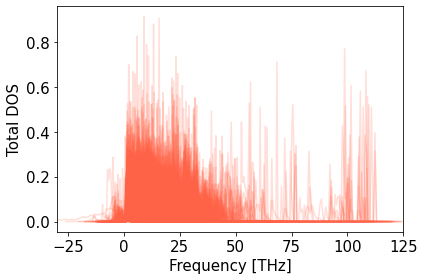

In [21]:
from sklearn.preprocessing import normalize

fig, ax = plt.subplots()

index = [*range (0, data.index[-1]+1)]
for i in index:
    dos = get_total_dos(i).reshape(1, -1)
    dos = normalize(dos)
    #dos = get_total_dos(i)/integral(i, 'total')
    freq = get_total_f(i)
    ax.plot(freq, dos[0], color='tomato', alpha=0.2)
    
ax.set_ylabel('Total DOS', fontsize=fs)
ax.set_xlabel('Frequency [THz]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(-30, 125)
#ax.set_ylim(0.0, 0.001)
plt.tight_layout()
plt.savefig('dos_total_overlay.pdf')
plt.show()

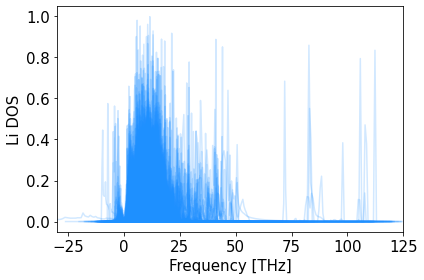

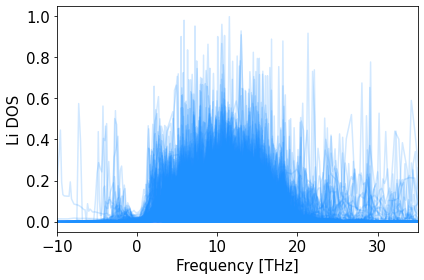

In [22]:
fig, ax = plt.subplots()

index = [*range (0, data.index[-1]+1)]
for i in index:
    dos = get_partial_dos(i).reshape(1, -1)
    dos = normalize(dos)
    #dos = get_partial_dos(i)/integral(i, 'partial')
    freq = get_partial_f(i)
    ax.plot(freq, dos[0], color='dodgerblue', alpha=0.2)
    
ax.set_ylabel('Li DOS', fontsize=fs)
ax.set_xlabel('Frequency [THz]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(-30, 125)
plt.tight_layout()
plt.savefig('dos_partial_overlay.pdf')
plt.show()

fig, ax = plt.subplots()

index = [*range (0, data.index[-1]+1)]
for i in index:
    dos = get_partial_dos(i).reshape(1, -1)
    dos = normalize(dos)
    freq = get_partial_f(i)
    ax.plot(freq, dos[0], color='dodgerblue', alpha=0.2)
    
ax.set_ylabel('Li DOS', fontsize=fs)
ax.set_xlabel('Frequency [THz]', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax.set_xlim(-10, 35)
plt.tight_layout()
#plt.savefig('dos_partial_overlay_zoom.pdf')
plt.show()

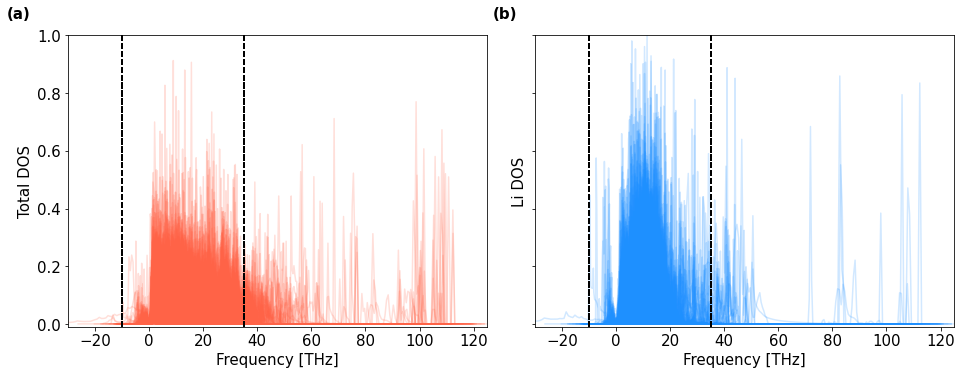

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(13.5, 5), sharey=True)

index = [*range (0, data.index[-1]+1)]
colors = ['tomato', 'dodgerblue']
ylabel = ['Total DOS', 'Li DOS']

for i in index:
    for j in range(0, 2):
        if j == 0:
            dos = get_total_dos(i).reshape(1,-1)
        else:
            dos = get_partial_dos(i).reshape(1,-1)
        dos = normalize(dos)
        freq = get_total_f(i)
        ax[j].plot(freq, dos[0], color=colors[j], alpha=0.2)
        ax[j].set_xlabel('Frequency [THz]', fontsize=fs)
        ax[j].set_ylabel(ylabel[j], fontsize=fs)
        ax[j].tick_params(axis='both', which='major', labelsize=fs)
        ax[j].set_xlim(-30, 125)
        ax[j].set_ylim(-0.01, 1.0)
        ax[j].axvline(-10, linestyle='--', color='k')
        ax[j].axvline(35, linestyle='--', color='k')

fig.text(0, 1, '(a)', fontsize=fs, weight='bold')
fig.text(0.5, 1, '(b)', fontsize=fs, weight='bold')
fig.tight_layout()

plt.savefig('dos_overlay.pdf')
plt.show()

# Get descriptors

In [24]:
def get_all_data (index):
    '''output four lists of data based on index input'''
    
    total_dos = get_total_dos(index)
    total_f = get_total_f(index)
    projected_dos = get_partial_dos (index)
    projected_f = get_partial_f (index)
    
    return total_dos,total_f,projected_dos,projected_f

# Phonon band-centre

In [25]:
def get_fav (index, dos):
    '''Get a temperature independent phonon band centre value'''
    if dos == 'total':
        f = get_total_f(index)
        d = get_total_dos(index)
    if dos == 'partial':
        f = get_partial_f(index)
        d = get_partial_dos(index)
    
    fav_elements = f * d
    fav = np.sum(fav_elements)
    norm = np.sum(d)
    fav = fav / norm
    return fav

In [26]:
k = scipy.constants.k
h = scipy.constants.h

def get_favT (index, dos, Tmin, Tmax, Tstep):
    '''Get a list of temperature dependent phonon band centre values or a single value at given T values'''
    favT = []

    if ((Tmin != None) and (Tmax == None) and (Tstep == None)):
        Temperature = [Tmin]
    elif ((Tmin != None) and (Tmax != None) and (Tstep != None)):
        Temperature = [*range(Tmin, Tmax, Tstep)]
    else:
        print("Tmin is expected as a value, Tmax and Tstep could be None")
        Temperature = None

    if dos == 'total':
        f = get_total_f(index)
        d = get_total_dos(index)
    if dos == 'partial':
        f = get_partial_f(index)
        d = get_partial_dos(index)
        
    #index of first-positive value - only consider positive frequencies
    idx_pos = [i for i, f_val in enumerate(f) if f_val>0]
    idx = idx_pos[0]
    f = f[idx:]
    d = d[idx:]

    for T in Temperature:
        #calculate phonon numbers
        #handling 0K
        if T == 0:
            ph_numbers = [0.5]*len(f)
        else:
            ph_numbers = []
            for f_val in f:
                energy = f_val*h*10**12
                beta = 1/(k*T)
                denominator = math.exp(energy*beta) - 1
                ph_number = 1/denominator
                ph_numbers.append(ph_number)


        fav_elements = f * d * ph_numbers
        norm_elements = d * ph_numbers

        fav = np.sum(fav_elements)
        norm = np.sum(norm_elements)
        fav = fav / norm
        favT.append(fav)

    return favT

Add an empty column for temperature independent phonon band centre

In [27]:
data['fav'] = np.nan
data['fav_tot'] = np.nan
data

,material_id,elements,formula_pretty_reduced,formula,num_elements,chemsys,spacegroup_symbol,spacegroup_number,fav,fav_tot
0,mp-8892,"[Li, F, In]",LiInF4,Li4 In4 F16,3,F-In-Li,Pbcn,60,NaN,NaN
1,mp-772968,"[Li, Tl, P, H, O]",LiTlPHO3,Li4 Tl4 P4 H4 O12,5,H-Li-O-P-Tl,C2,5,NaN,NaN
2,mp-756951,"[Li, Sb, O]",LiSbO3,Li4 Sb4 O12,3,Li-O-Sb,C2/m,12,NaN,NaN
3,mp-754856,"[Li, Y, Zr, S]",Li7Y7ZrS16,Li7 Y7 Zr1 S16,4,Li-S-Y-Zr,P2/m,10,NaN,NaN
4,mp-24610,"[H, Li, O, P]",LiP(HO2)2,Li4 P4 H8 O16,4,H-Li-O-P,Pna2_1,33,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
868,mp-9919,"[Li, Zn, Sb]",LiZnSb,Li2 Zn2 Sb2,3,Li-Sb-Zn,P6_3mc,186,NaN,NaN
869,mp-14704,"[Li, B, O, Y]",Li6Y(BO3)3,Li24 Y4 B12 O36,4,B-Li-O-Y,P2_1/c,14,NaN,NaN
870,mp-557756,"[Li, Zn, P, O]",Li4Zn(PO4)2,Li16 Zn4 P8 O32,4,Li-O-P-Zn,P2_1/c,14,NaN,NaN
871,mp-966801,"[Li, Ca, B, O]",LiCaBO3,Li8 Ca8 B8 O24,4,B-Ca-Li-O,Ibca,73,NaN,NaN


Get temperature independent phonon band centers for all the species

In [28]:
index = [*range (0, data.index[-1]+1)]
for i in index:
    fav = get_fav(i, 'partial')
    fav_tot = get_fav(i, 'total')
    data.at[i,'fav'] = fav
    data.at[i,'fav_tot'] = fav_tot

Get temperature dependent phonon band center (room temperature) for all the species

In [29]:
Tmin = 298
Tmax = None
Tstep = None

if ((Tmin != None) and (Tmax == None) and (Tstep == None)):
    Temperature = [Tmin]
elif ((Tmin != None) and (Tmax != None) and (Tstep != None)):
    Temperature = [*range(Tmin, Tmax, Tstep)]
else:
    print("Tmin is expected as a value, Tmax and Tstep could be None")
    Temperature = None


index = [*range (0, data.index[-1]+1)]
t_val = pd.DataFrame(columns=['298_tot'])
li_val = pd.DataFrame(columns=['298'])
for i in index:
    fav_t = get_favT(i, 'partial', Tmin, Tmax, Tstep)
    fav_li = get_favT(i, 'total', Tmin, Tmax, Tstep)
    t_val.loc[i] = fav_t
    li_val.loc[i] = fav_li
    
data = pd.concat([data, t_val], axis = 1)
data = pd.concat([data, li_val], axis = 1)

Get temperature dependent phonon band center in a temperature range for all the species, example here using 10 to 1000k with a step of 10k

In [30]:
Tmin = 10
Tmax = 1000
Tstep = 10

if ((Tmin != None) and (Tmax == None) and (Tstep == None)):
    Temperature = [Tmin]
elif ((Tmin != None) and (Tmax != None) and (Tstep != None)):
    Temperature = [*range(Tmin, Tmax, Tstep)]
else:
    print("Tmin is expected as a value, Tmax and Tstep could be None")
    Temperature = None


index = [*range (0, data.index[-1]+1)]
T_val = pd.DataFrame(columns = Temperature)
for i in index:
    favT = get_favT(i, 'partial', Tmin, Tmax, Tstep)
    T_val.loc[i] = favT

data = pd.concat([data, T_val], axis = 1)


In [31]:
data

,material_id,elements,formula_pretty_reduced,formula,num_elements,chemsys,spacegroup_symbol,spacegroup_number,fav,fav_tot,...,900,910,920,930,940,950,960,970,980,990
0,mp-8892,"[Li, F, In]",LiInF4,Li4 In4 F16,3,F-In-Li,Pbcn,60,11.132426,8.450140,...,9.622918,9.627107,9.631197,9.635190,9.639090,9.642901,9.646625,9.650265,9.653824,9.657305
1,mp-772968,"[Li, Tl, P, H, O]",LiTlPHO3,Li4 Tl4 P4 H4 O12,5,H-Li-O-P-Tl,C2,5,12.800916,21.721623,...,9.804592,9.813504,9.822202,9.830693,9.838985,9.847085,9.854999,9.862734,9.870295,9.877688
2,mp-756951,"[Li, Sb, O]",LiSbO3,Li4 Sb4 O12,3,Li-O-Sb,C2/m,12,8.819405,11.408661,...,7.533812,7.536527,7.539180,7.541773,7.544308,7.546787,7.549212,7.551584,7.553905,7.556178
3,mp-754856,"[Li, Y, Zr, S]",Li7Y7ZrS16,Li7 Y7 Zr1 S16,4,Li-S-Y-Zr,P2/m,10,6.245816,6.055796,...,5.747567,5.748375,5.749165,5.749937,5.750691,5.751430,5.752152,5.752858,5.753550,5.754227
4,mp-24610,"[H, Li, O, P]",LiP(HO2)2,Li4 P4 H8 O16,4,H-Li-O-P,Pna2_1,33,38.676281,21.873600,...,19.990915,20.104714,20.216033,20.324942,20.431509,20.535803,20.637886,20.737823,20.835672,20.931493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,mp-9919,"[Li, Zn, Sb]",LiZnSb,Li2 Zn2 Sb2,3,Li-Sb-Zn,P6_3mc,186,6.350430,4.587253,...,5.693411,5.694497,5.695558,5.696595,5.697609,5.698600,5.699569,5.700516,5.701444,5.702351
869,mp-14704,"[Li, B, O, Y]",Li6Y(BO3)3,Li24 Y4 B12 O36,4,B-Li-O-Y,P2_1/c,14,11.867930,14.840322,...,8.646174,8.654130,8.661905,8.669505,8.676937,8.684205,8.691314,8.698270,8.705078,8.711743
870,mp-557756,"[Li, Zn, P, O]",Li4Zn(PO4)2,Li16 Zn4 P8 O32,4,Li-O-P-Zn,P2_1/c,14,12.278804,14.092563,...,9.961839,9.968482,9.974967,9.981302,9.987490,9.993537,9.999447,10.005226,10.010877,10.016405
871,mp-966801,"[Li, Ca, B, O]",LiCaBO3,Li8 Ca8 B8 O24,4,B-Ca-Li-O,Ibca,73,10.403979,14.003078,...,8.861610,8.865376,8.869055,8.872650,8.876164,8.879599,8.882959,8.886245,8.889461,8.892608


## First frequency with non-negligible Li DOS

Using scipy find_peaks()

In [32]:
def first_peak_f(index, frac_max=0.5):
    '''Get frequency of the first peak in the Li DOS from scipy find_peaks() function'''
    '''Threshold for peak height is a fraction frac_max of the maximum value'''
    '''Default is set to a half the maximum'''
    Li_f = get_partial_f(index)
    Li_d = normalize(get_partial_dos(index).reshape(1, -1))[0]
    max_h = max(Li_d)
    h = max_h*frac_max
    first_peak_index = find_peaks(Li_d, height=h)[0][0]
    f = Li_f[first_peak_index]
    return f

Write frequencies to dataframe

In [33]:
fractions = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

index = [*range (0, data.index[-1]+1)]
f_val = pd.DataFrame(columns = fractions)
for i in index:
    first_frequencies = []
    for frac in fractions: 
        ff = first_peak_f(i, frac)
        first_frequencies.append(ff)
    f_val.loc[i] = first_frequencies

data = pd.concat([data, f_val], axis = 1)

## Relative spread of the DOS

In [34]:
def relative_s (index, threshold=0.001):
    '''get Li DOS spread above a threshold relative to the total spread'''
    '''In phonopy, the DOS doesn't go to zero'''
    '''so we need to set a threshold where we consider that the DOS is zero'''
    '''Threshold is 0.001'''

    total_d = get_total_dos(index)
    total_d_n = normalize(total_d.reshape(1, -1))[0]
    Li_d = get_partial_dos(index)
    Li_d_n = normalize(Li_d.reshape(1, -1))[0]

    #count above threshold
    c_total = sum(d > threshold for d in total_d_n)
    c_partial = sum(d > threshold for d in Li_d_n)

    #relative spread is (step*c_partial)/(step*c_total)
    relative_s = c_partial / c_total

    return relative_s

Write relative spread using thresholds of 0.001 and 0.01

In [35]:
thresholds = [0.00001, 0.0001, 0.001, 0.01]

index = [*range (0, data.index[-1]+1)]
p_val = pd.DataFrame(columns = thresholds)
for i in index:
    spread = []
    for t in thresholds: 
        s = relative_s(i, t)
        spread.append(s)
    p_val.loc[i] = spread

data = pd.concat([data, p_val], axis = 1)

In [36]:
data

,material_id,elements,formula_pretty_reduced,formula,num_elements,chemsys,spacegroup_symbol,spacegroup_number,fav,fav_tot,...,0.1,0.2,0.3,0.4,0.5,0.6,1e-05,0.0001,0.001,0.01
0,mp-8892,"[Li, F, In]",LiInF4,Li4 In4 F16,3,F-In-Li,Pbcn,60,11.132426,8.450140,...,9.190986,9.927689,9.927689,9.927689,9.927689,9.927689,0.993939,0.981707,0.962025,0.788732
1,mp-772968,"[Li, Tl, P, H, O]",LiTlPHO3,Li4 Tl4 P4 H4 O12,5,H-Li-O-P-Tl,C2,5,12.800916,21.721623,...,11.140249,11.140249,11.140249,14.066884,14.066884,14.066884,1.000000,0.925000,0.725000,0.555556
2,mp-756951,"[Li, Sb, O]",LiSbO3,Li4 Sb4 O12,3,Li-O-Sb,C2/m,12,8.819405,11.408661,...,4.864107,5.543978,5.543978,5.543978,5.543978,6.903721,1.000000,0.993865,0.906832,0.560606
3,mp-754856,"[Li, Y, Zr, S]",Li7Y7ZrS16,Li7 Y7 Zr1 S16,4,Li-S-Y-Zr,P2/m,10,6.245816,6.055796,...,4.319241,4.319241,4.319241,4.319241,5.047983,5.047983,0.987952,0.962963,0.921569,0.735294
4,mp-24610,"[H, Li, O, P]",LiP(HO2)2,Li4 P4 H8 O16,4,H-Li-O-P,Pna2_1,33,38.676281,21.873600,...,29.153401,29.153401,32.155099,32.155099,32.155099,32.155099,1.000000,0.988506,0.941860,0.537500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,mp-9919,"[Li, Zn, Sb]",LiZnSb,Li2 Zn2 Sb2,3,Li-Sb-Zn,P6_3mc,186,6.350430,4.587253,...,4.292991,4.292991,7.108637,7.108637,7.108637,7.108637,0.987578,0.968750,0.876623,0.664286
869,mp-14704,"[Li, B, O, Y]",Li6Y(BO3)3,Li24 Y4 B12 O36,4,B-Li-O-Y,P2_1/c,14,11.867930,14.840322,...,5.185502,5.979421,6.508700,7.567257,11.272210,11.272210,1.000000,0.982143,0.812500,0.742574
870,mp-557756,"[Li, Zn, P, O]",Li4Zn(PO4)2,Li16 Zn4 P8 O32,4,Li-O-P-Zn,P2_1/c,14,12.278804,14.092563,...,4.985237,8.758697,8.758697,8.758697,8.758697,10.855064,1.000000,0.967480,0.811475,0.700935
871,mp-966801,"[Li, Ca, B, O]",LiCaBO3,Li8 Ca8 B8 O24,4,B-Ca-Li-O,Ibca,73,10.403979,14.003078,...,5.331724,7.424524,10.040524,10.040524,10.040524,10.040524,0.989011,0.933333,0.771084,0.735294


## Write the result dataframe into a csv file

In [37]:
data.to_csv('data.csv')

## Featurising the DOS into a vector using interpolation

In [38]:
data.iloc[652]

material_id                     mp-557328
elements                  [Li, Zn, Sb, O]
formula_pretty_reduced         Li3Zn2SbO6
formula                   Li6 Zn4 Sb2 O12
num_elements                            4
                               ...       
0.6                              6.163993
1e-05                                 1.0
0.0001                           0.993939
0.001                            0.969136
0.01                              0.84106
Name: 652, Length: 120, dtype: object

### Check different point densities

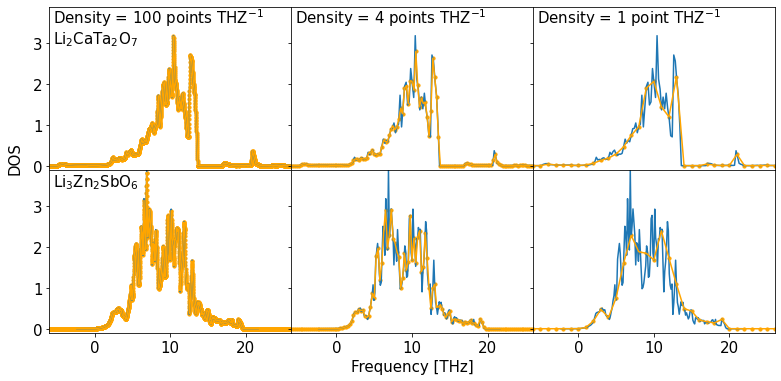

In [133]:
fig = plt.figure(figsize=(13,6))
gs = fig.add_gridspec(2, 3, hspace=0, wspace=0)
ax = gs.subplots(sharex=True, sharey=True)
#fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(13,6))
fig_subnum = ['(a)']

for j, density in enumerate([100, 4, 1]):

    for i, idx in enumerate([45, 652]):
        fr = get_total_f(idx)
        d = get_partial_dos(idx)
        f = interpolate.interp1d(fr, d, fill_value=0, bounds_error=False)

        start = -10
        end = 35
        step = 1/density
        fr_new = np.arange(start, end, step)
        d_interp = f(fr_new)

        ax[i][j].plot(fr, d, label='True')
        ax[i][j].plot(fr_new, d_interp, color='orange', label='Interpolated')
        ax[i][j].scatter(fr_new, d_interp, color='orange', s=10)
        ax[i][j].tick_params(axis='both', which='major', labelsize=fs)
        ax[i][j].set_ylim(-0.1,3.9)
        ax[i][j].set_xlim(-6,26)
        if i == 0:
            if j == 2:
                ax[i][j].annotate(r'Density = '+str(density)+' point THZ$^{-1}$', xy=(-5.5, 3.5), fontsize=fs)
            else:
                ax[i][j].annotate(r'Density = '+str(density)+' points THZ$^{-1}$', xy=(-5.5, 3.5), fontsize=fs)

ax[0][0].annotate('Li$_2$CaTa$_2$O$_7$', xy=(-5.5, 3), fontsize=fs)
ax[1][0].annotate('Li$_3$Zn$_2$SbO$_6$', xy=(-5.5, 3.5), fontsize=fs)
ax[1][1].set_xlabel('Frequency [THz]', fontsize=fs)
fig.text(0.08, 0.5, 'DOS', rotation=90, fontsize=fs)
plt.savefig('dos_featurisation_ptdensity.pdf')
plt.show()

### Get DOS feature vectors

In [104]:
def dos_featuriser(index, dos, density=4):
    '''Featurise the DOS into a vector using interpolation'''
    '''density=4 is good'''
    fr = get_total_f(i)
    if dos == 'total':
        d = get_total_dos(i)
    elif dos == 'partial':
        d = get_partial_dos(i)
    f = interpolate.interp1d(fr, d, fill_value=0, bounds_error=False)
    
    start = -10
    end = 35
    step = 1/density
    fr_new = np.arange(start, end, step)
    d_interp = f(fr_new)
    
    return d_interp

In [105]:
missing_id = ['mp-867700', 'mp-613442', 'mp-867699', 'mp-867677', 'mp-561623', 'mp-867712']
missing_idx = []

for mat in missing_id: 
    idx = data[data.material_id == mat].index
    missing_idx.append(idx)
    
missing_idx

[Int64Index([831], dtype='int64'),
 Int64Index([832], dtype='int64'),
 Int64Index([199], dtype='int64'),
 Int64Index([287], dtype='int64'),
 Int64Index([307], dtype='int64'),
 Int64Index([5], dtype='int64')]

In [107]:
index = [*range(0, data.index[-1]+1)]
for idx in missing_idx:
    index.remove(idx)
tot_list = []
li_list = []
all_list = []
for i in index:
    fvt = dos_featuriser(i, 'total')
    fvli = dos_featuriser(i, 'partial')
    all_list.append(np.concatenate((fvt, fvli)))
    tot_list.append(fvt)
    li_list.append(fvli)

tot_arr = np.array(tot_list)
li_arr = np.array(li_list)
all_arr = np.array(all_list)
#print(np.shape(all_arr))

Write the result to a binary file

In [108]:
np.save('vibtot_feature', tot_arr)
np.save('vibli_feature', li_arr)
np.save('viball_feature', all_arr)